<a href="https://www.kaggle.com/code/muhammmadkamilkhan/txt-generation-using-lstm?scriptVersionId=192642731" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string,os
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore',category=FutureWarning)

#loading deep learning libraries
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout,Embedding
import keras.utils as ku
from keras.callbacks import EarlyStopping

2024-08-14 13:22:30.790675: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-14 13:22:30.790823: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-14 13:22:30.956850: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading The Data Set

The dataset contains various articles and comments. Our objective is to load all the articles as headlines and merge them into a list.

**Objective:**
The goal of this code is to load and preprocess news article headlines from a CSV file located in a specified directory. It collects all headlines from the CSV files that include the word 'Articles' in their filename and then filters out any headlines labeled as 'Unknown'.

In [2]:
curr_path = '/kaggle/input/nyt-comments/'
all_headlines = []
for filename in os.listdir(curr_path):
    if 'Articles' in filename:
        article_df = pd.read_csv(curr_path + filename)
        all_headlines.extend(list(article_df.headline.values))
        break
all_headines = [line for line in all_headlines if line!= 'Unknown']
print(all_headlines[:10])

['N.F.L. vs. Politics Has Been Battle All Season Long', 'Voice. Vice. Veracity.', 'A Stand-Up’s Downward Slide', 'New York Today: A Groundhog Has Her Day', 'A Swimmer’s Communion With the Ocean', 'Trail Activity', 'Super Bowl', 'Trump’s Mexican Shakedown', 'Pence’s Presidential Pet', 'Fruit of a Poison Tree']


# Preparation of Data


## Cleaning The Data set
This code is designed to clean and preprocess a list of text headlines by removing punctuation, converting text to lowercase, and handling any non-ASCII characters.the purpose of this is to prepare the text for further analysis or modeling.

In [3]:
def clean_text(txt):
    txt = ''.join(t for t in txt if t not in string.punctuation).lower()
    txt = txt.encode('utf8').decode('ascii','ignore')
    return txt
corpus = [clean_text(x) for x in all_headlines]
print(corpus[:10])

['nfl vs politics has been battle all season long', 'voice vice veracity', 'a standups downward slide', 'new york today a groundhog has her day', 'a swimmers communion with the ocean', 'trail activity', 'super bowl', 'trumps mexican shakedown', 'pences presidential pet', 'fruit of a poison tree']


## Generating Sequence and Tokenization

In NLP language model requires sequential input data, and input word/token must be numerical. Here we are generating n-grams in order to train our model for next word prediction.

In [4]:
tokenizer = Tokenizer()
def get_sequence_tokens(corpus):
    tokenizer.fit_on_texts(corpus)# tokenization process
    total_words = len(tokenizer.word_index) +1
    
    input_seq = [] # converting txt to token sequences
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1,len(token_list)):
            n_gram_seq = token_list[:i+1]
            input_seq.append(n_gram_seq)
    return input_seq,total_words
input_sequence , total_words = get_sequence_tokens(corpus)
input_sequence[:10]

[[661, 118],
 [661, 118, 73],
 [661, 118, 73, 74],
 [661, 118, 73, 74, 662],
 [661, 118, 73, 74, 662, 663],
 [661, 118, 73, 74, 662, 663, 64],
 [661, 118, 73, 74, 662, 663, 64, 30],
 [661, 118, 73, 74, 662, 663, 64, 30, 211],
 [212, 664],
 [212, 664, 665]]

## Sequence Padding

This function takes input_sequences (the token sequences generated from the previous step) as input and processes them to produce padded sequences and labels.

Machine learning models, particularly neural networks, often require inputs of the same size. Padding ensures that all input sequences have the same length, which is necessary for batch processing.
The goal is to train the model to predict the next word in a sequence. The predictors (all tokens except the last one) serve as the input, and the label (the last token) is what the model should predict.

In [5]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequence, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors_X, label_y, max_sequence_len = generate_padded_sequences(input_sequence)
max_sequence_len

17

# Model Creation

In [6]:
def create_model(max_sequence_len,total_words):
    input_len = max_sequence_len-1
    model = Sequential()
    model.add(Embedding(input_dim = total_words,output_dim =10,input_length = input_len))
    model.add(LSTM(100))
    model.add(Dropout(0.1))
    model.add(Dense(total_words,activation ='softmax'))
    model.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics=['accuracy'])
    return model
model = create_model(max_sequence_len,total_words)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Model Training

In [7]:
history = model.fit(predictors_X, label_y, epochs=100, verbose=5)

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

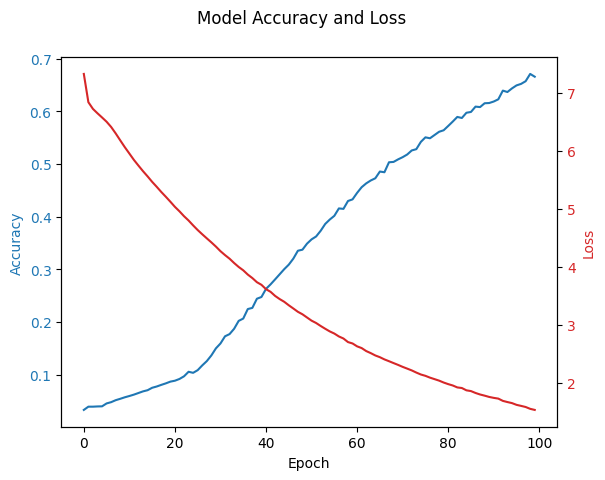

In [8]:
import matplotlib.pyplot as plt

# Create a new figure
fig, ax1 = plt.subplots()

# Plot training accuracy on the first y-axis
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.plot(history.history['accuracy'], label='Accuracy', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for the loss
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
ax2.plot(history.history['loss'], label='Loss', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add a title
fig.suptitle('Model Accuracy and Loss')

plt.show()

# Generating Text: (doing prediction)

In [9]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def generate_text(seed_text, next_words, model, max_sequence_len):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    
    # Predict probabilities for each word in the vocabulary
    predicted_probs = model.predict(token_list, verbose=0)
    
    # Get the predicted class (word) with the highest probability
    predicted_class = np.argmax(predicted_probs, axis=-1)
    
    # Map the index back to the word
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted_class:
            output_word = word
            break

    # Generate the next sequence
    seed_text += " " + output_word
    for _ in range(next_words - 1):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)
        predicted_class = np.argmax(predicted_probs, axis=-1)
        
        for word, index in tokenizer.word_index.items():
            if index == predicted_class:
                output_word = word
                break
        
        seed_text += " " + output_word
    
    return seed_text

# Example usage
print(generate_text("pakistan and afghanistan", 5, model, max_sequence_len))
print(generate_text("england cricket team", 10, model, max_sequence_len))
print(generate_text("i love", 3, model, max_sequence_len))
print(generate_text("A programmer can do ", 8, model, max_sequence_len))

pakistan and afghanistan lessons from resistance on familiar
england cricket team the lakers world turns a revolution is the mirror and
i love hits a brick
A programmer can do  wont make the alzheimers treatment can its kind
